In [1]:
import random
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import tifffile as tiff

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import numpy as np

from patchify import patchify, unpatchify
from sklearn.metrics import jaccard_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [5]:
smooth = 1e-12
def jaccard_coef(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [6]:
model = load_model('unet_model.h5',custom_objects={'jaccard_coef': jaccard_coef})

In [7]:
def stretch_n(img, lower_percent=5, higher_percent=95):    
    '''
    adjusting the contrast of images and getting values in a range
    '''
    # https://www.kaggle.com/aamaia/rgb-using-m-bands-example
    out = np.zeros_like(img, dtype=np.float32)
    n = img.shape[2]
    for i in range(n):
        a = 0       # np.min(img)
        b = 1       # np.max(img)
        c = np.percentile(img[:, :, i], lower_percent)
        d = np.percentile(img[:, :, i], higher_percent)
        t = a + (img[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t
    return out.astype(np.float32)

In [37]:
def band_8(image_id, size=800):
    '''
    getting 8 band images i.e M Bands
    '''
    filename = "sixteen_band/{}_M.tif".format(image_id)
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img

In [41]:
def load_image_patch(image_id):
    img = stretch_n(band_8(image_id))    
    mask = tiff.imread('masks/'+image_id+'.tif')
    
    patch_maskid = patchify(mask,(160,160,10),step=160)
    patch_maskid = patch_maskid[:,:,0,:,:,:]
    
    patch_imgid = patchify(img,(160,160,8),step=160)
    patch_imgid = patch_imgid[:,:,0,:,:,:]
    
    patch_images = np.zeros((patch_imgid.shape[0]*patch_imgid.shape[1], 160, 160,8))
    patch_mask = np.zeros((patch_maskid.shape[0]*patch_maskid.shape[1], 160, 160,10))
    c = 0
    for i in range(patch_imgid.shape[0]):
        for j in range(patch_imgid.shape[1]):
            #structuring for prediction
            patch_images[c,:,:,:] = patch_imgid[i,j,:,:,:]
            patch_mask[c,:,:,:] = patch_maskid[i,j,:,:,:]
            c+=1
    patch_images = 2 * np.transpose(patch_images, (0, 3, 1, 2)) - 1
    patch_mask = np.transpose(patch_mask, (0, 3, 1, 2))
    return patch_images,patch_mask
    

In [42]:
def cal_jaccard_score(image_id):

    N_Cls = 10
    
    tr = [0.4, 0.3, 0.4, 0.4, 0.4, 0.6, 0.6, 0.5, 0.1, 0.2] #threshold
    
    patch_images,patch_mask = load_image_patch(image_id)
    
    prd = model.predict(patch_images)
    avg = []

    for i in range(N_Cls): #going through each class
        t_msk = patch_mask[:, i, :, :]
        t_prd = prd[:, i, :, :]

        #reshaping to 2D
        t_msk = t_msk.reshape(patch_mask.shape[0] * patch_mask.shape[2], patch_mask.shape[3])
        t_prd = t_prd.reshape(patch_mask.shape[0] * patch_mask.shape[2], patch_mask.shape[3])
        
        pred_mask_threshold = t_prd > tr[i] #creating binary from threshold
        js = jaccard_score(t_msk, pred_mask_threshold,average = 'micro') # calculate jaccard similarity for predict mask and actual mask
        avg.append(round(js,2))

    score = sum(avg) / 10.0
    return score

In [43]:
cal_jaccard_score('6120_2_0')

0.479

In [18]:
DF = pd.read_csv('train_wkt_v4/train_wkt_v4.csv')
DF.head()

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...


## Low Jaccard Score

In [19]:
low_jaccard ={}
for ele in DF['ImageId'].unique():
    jaccard = cal_jaccard_score(ele)
    if jaccard <0.2:
        low_jaccard[ele] = jaccard
low_jaccard

{'6040_2_2': 0.137,
 '6040_1_0': 0.135,
 '6010_4_2': 0.124,
 '6160_2_1': 0.122,
 '6010_4_4': 0.075,
 '6170_4_1': 0.122,
 '6170_0_4': 0.132,
 '6010_1_2': 0.13599999999999998,
 '6040_4_4': 0.126}

In [20]:
low_jaccard_df = DF[DF['ImageId'].isin(list(low_jaccard.keys()))]
low_jaccard_df.head()

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...


In [21]:
from shapely import wkt, affinity
from shapely.wkt import loads

low_jaccard_df['Multipolygons'] = low_jaccard_df.apply(lambda a: loads(a.MultipolygonWKT), axis=1)
low_jaccard_df['Num_Multipolygons'] = low_jaccard_df.apply(lambda a: len(a['Multipolygons'].geoms), axis=1) #https://stackoverflow.com/questions/38930192/how-to-extract-polygons-from-multipolygons-in-shapely
objects_per_image = low_jaccard_df.pivot(index='ClassType', columns='ImageId', values='Num_Multipolygons')
objects_per_image.T

ClassType,1,2,3,4,5,6,7,8,9,10
ImageId,,,,,,,,,,
6010_1_2,0,44,0,12,1733,0,0,0,0,0
6010_4_2,0,0,0,6,2262,0,0,0,0,0
6010_4_4,0,0,0,0,3860,0,0,0,0,0
6040_1_0,0,0,0,5,2446,0,0,0,0,0
6040_2_2,0,0,0,2,3879,0,0,0,0,0
6040_4_4,0,0,0,7,1901,0,0,0,0,0
6160_2_1,0,0,0,8,2432,0,0,0,0,0
6170_0_4,0,1,0,9,2774,0,0,8,0,0
6170_4_1,0,0,0,2,4245,0,0,0,0,0


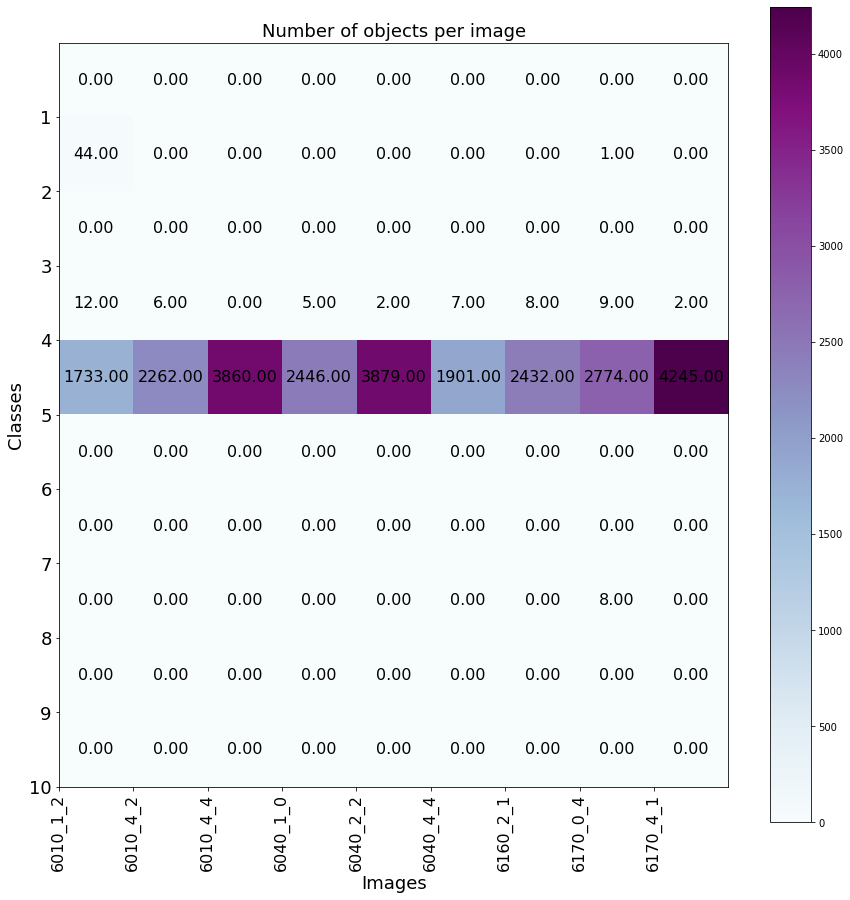

In [27]:
%matplotlib inline
figure, axis = plt.subplots(figsize=(15, 15))
axis.set_aspect('equal')  #keep x-unit and y-unit ratio equal
plt.imshow(objects_per_image, cmap='BuPu', extent=[0, len(list(low_jaccard.keys())), 10, 0])

for i in range(objects_per_image.shape[0]):
    for j in range(objects_per_image.shape[1]):
        plt.text(j+0.5, i+0.5, "{:.2f}".format(objects_per_image.iloc[i,j]), ha="center", va="center",fontsize=16)

plt.xticks(np.arange(0, len(list(low_jaccard.keys())), 1.0),list(objects_per_image.columns), rotation='vertical',fontsize=16)
plt.yticks(np.arange(1, 11, 1.0),fontsize=18)
plt.title('Number of objects per image',fontsize=18)
plt.xlabel('Images',fontsize=18)
plt.ylabel('Classes',fontsize=18)
plt.colorbar()
plt.show()

## Medium Jaccard Score

In [28]:
mid_jaccard ={}
for ele in DF['ImageId'].unique():
    jaccard = cal_jaccard_score(ele)
    if jaccard >=0.2 and jaccard < 0.6:
        mid_jaccard[ele] = jaccard
mid_jaccard

{'6120_2_2': 0.524,
 '6120_2_0': 0.479,
 '6090_2_0': 0.324,
 '6040_1_3': 0.221,
 '6100_1_3': 0.5389999999999999,
 '6110_4_0': 0.549,
 '6140_3_1': 0.5650000000000001,
 '6110_1_2': 0.453,
 '6100_2_3': 0.442,
 '6150_2_3': 0.262,
 '6140_1_2': 0.4800000000000001,
 '6110_3_1': 0.559,
 '6170_2_4': 0.292,
 '6060_2_3': 0.327,
 '6070_2_3': 0.388,
 '6100_2_2': 0.589}

In [29]:
mid_jaccard_df = DF[DF['ImageId'].isin(list(mid_jaccard.keys()))]
mid_jaccard_df.head()

,ImageId,ClassType,MultipolygonWKT
10,6120_2_2,1,MULTIPOLYGON (((0.000439 -0.009039999999999999...
11,6120_2_2,2,MULTIPOLYGON (((0.009154000000000001 -0.008422...
12,6120_2_2,3,"MULTIPOLYGON (((0.001095 -0.007676, 0.001103 -..."
13,6120_2_2,4,"MULTIPOLYGON (((0.007424 -0.008459, 0.007436 -..."
14,6120_2_2,5,"MULTIPOLYGON (((0.000494 -0.008805, 0.00048 -0..."


In [30]:
from shapely import wkt, affinity
from shapely.wkt import loads

mid_jaccard_df['Multipolygons'] = mid_jaccard_df.apply(lambda a: loads(a.MultipolygonWKT), axis=1)
mid_jaccard_df['Num_Multipolygons'] = mid_jaccard_df.apply(lambda a: len(a['Multipolygons'].geoms), axis=1) #https://stackoverflow.com/questions/38930192/how-to-extract-polygons-from-multipolygons-in-shapely
objects_per_image = mid_jaccard_df.pivot(index='ClassType', columns='ImageId', values='Num_Multipolygons')
objects_per_image.T

ClassType,1,2,3,4,5,6,7,8,9,10
ImageId,,,,,,,,,,
6040_1_3,0,0,0,1,3982,2,0,0,0,0
6060_2_3,62,173,0,7,1613,86,0,0,0,1
6070_2_3,109,81,2,0,41,0,24,3,0,13
6090_2_0,0,11,0,3,2308,7,0,19,0,1
6100_1_3,2208,1581,1,13,823,3,0,4,11,129
6100_2_2,633,454,1,27,878,11,4,1,13,101
6100_2_3,1690,1226,2,24,574,0,0,2,14,126
6110_1_2,1584,1420,1,10,855,28,0,63,0,23
6110_3_1,581,706,1,19,1239,35,0,9,3,25


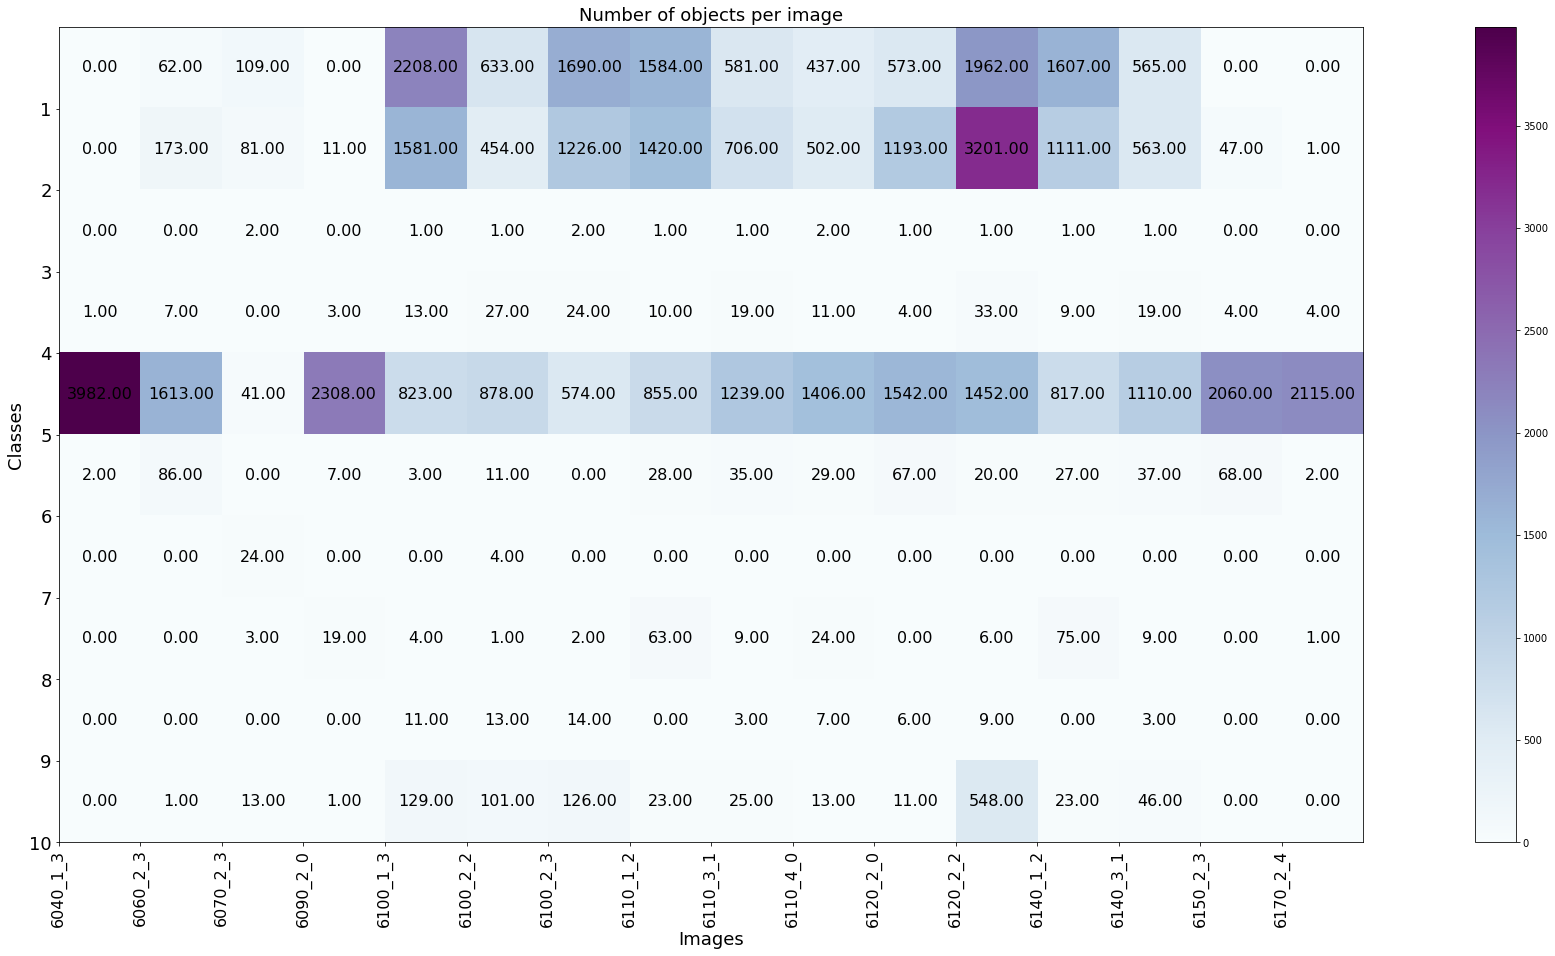

In [31]:
%matplotlib inline
figure, axis = plt.subplots(figsize=(40, 15))
axis.set_aspect('equal')  #keep x-unit and y-unit ratio equal
plt.imshow(objects_per_image, cmap='BuPu', extent=[0, len(list(mid_jaccard.keys())), 10, 0])

for i in range(objects_per_image.shape[0]):
    for j in range(objects_per_image.shape[1]):
        plt.text(j+0.5, i+0.5, "{:.2f}".format(objects_per_image.iloc[i,j]), ha="center", va="center",fontsize=16)

plt.xticks(np.arange(0, len(list(mid_jaccard.keys())), 1.0),list(objects_per_image.columns), rotation='vertical',fontsize=16)
plt.yticks(np.arange(1, 11, 1.0),fontsize=18)
plt.title('Number of objects per image',fontsize=18)
plt.xlabel('Images',fontsize=18)
plt.ylabel('Classes',fontsize=18)
plt.colorbar()
plt.show()

## Prediction on low jaccard score

In [44]:
#from kaggle
classes = ['Buildings',
            'Misc.',
            'Road',
            'Track',
            'Trees',
            'Crops',
            'Waterway', 
            'Standing water',
            'Vehicle Large',
            'Vehicle Small']

In [48]:
def pred(image_id):
    tr = [0.4, 0.3, 0.4, 0.4, 0.4, 0.6, 0.6, 0.5, 0.1, 0.2] #threshold
    patch_images,_ = load_image_patch(image_id)
    
    pred_mask = model.predict(patch_images)
    pred_mask = np.transpose(pred_mask,(0, 2,3,1))
    
    for i in range(len(pred_mask)):
        for j in range(10):
            pred_mask[i,j,:,:] = pred_mask[i,j,:,:]>tr[j]
    unpatch = np.zeros((5,5,160,160,10))
    c = 0
    for i in range(5):
        for j in range(5):
            unpatch[i,j,:,:,:] = pred_mask[c,:,:,:]
            c+=1
    unpatched_prediction = unpatchify(np.expand_dims(unpatch,axis=2),(800,800,10))
    
    return unpatched_prediction

In [49]:
def plot_mask(image_id):
    mask = tiff.imread('masks/'+image_id+'.tif')
    prediction = pred(image_id)
    for ele in range(10): #going through prediction of all classes
        fig,ax = plt.subplots(1,2,figsize=(25,10))
        ax[0].imshow(mask[:,:,ele], cmap=plt.get_cmap('gray'))
        ax[1].imshow(prediction[:,:,ele], cmap=plt.get_cmap('gray'))
        ax[0].set_title('original segmentation of '+classes[ele])
        ax[1].set_title('predicted segmentation '+classes[ele])
        plt.show()


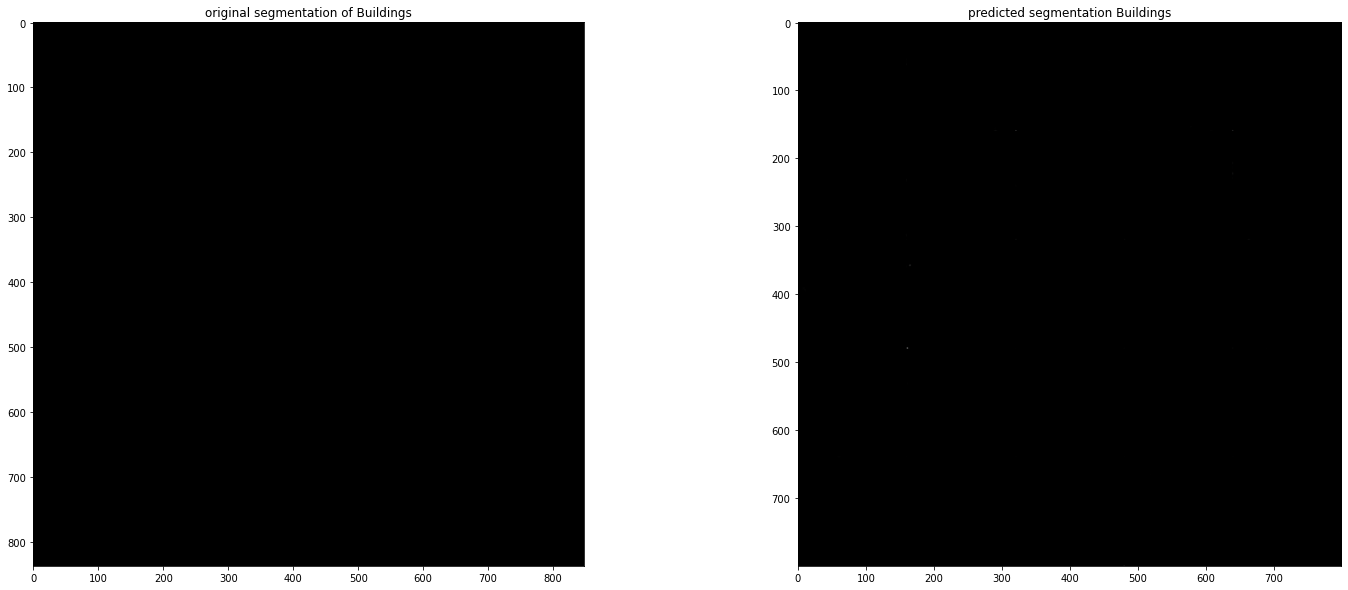

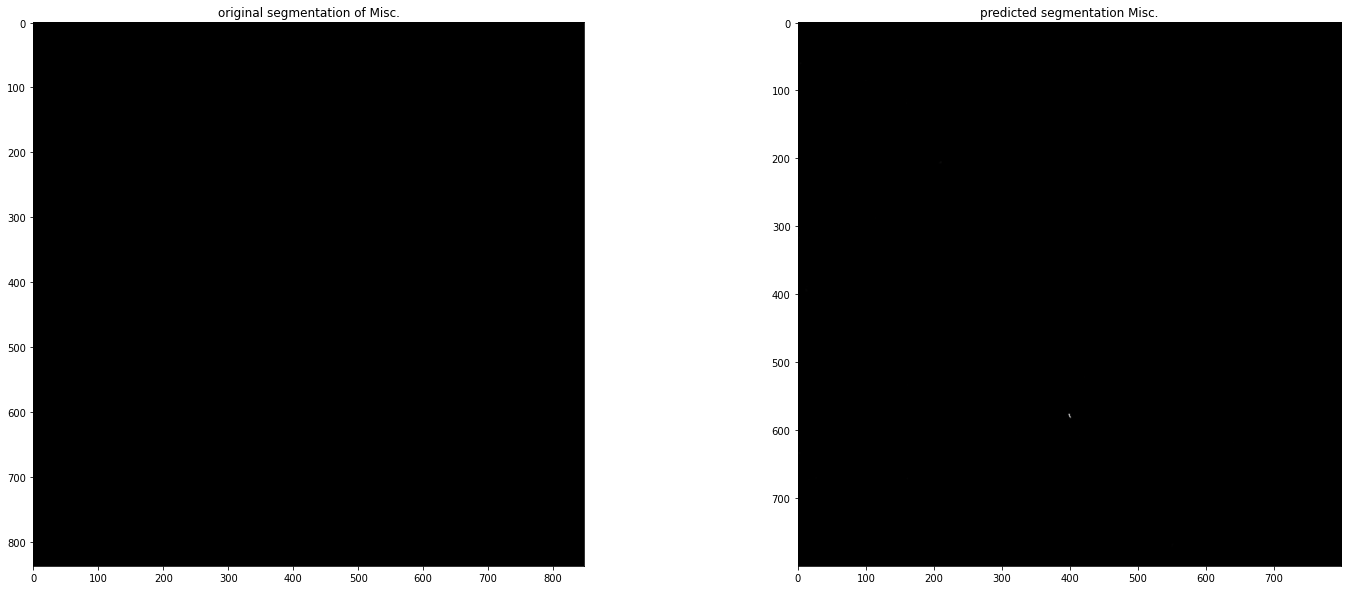

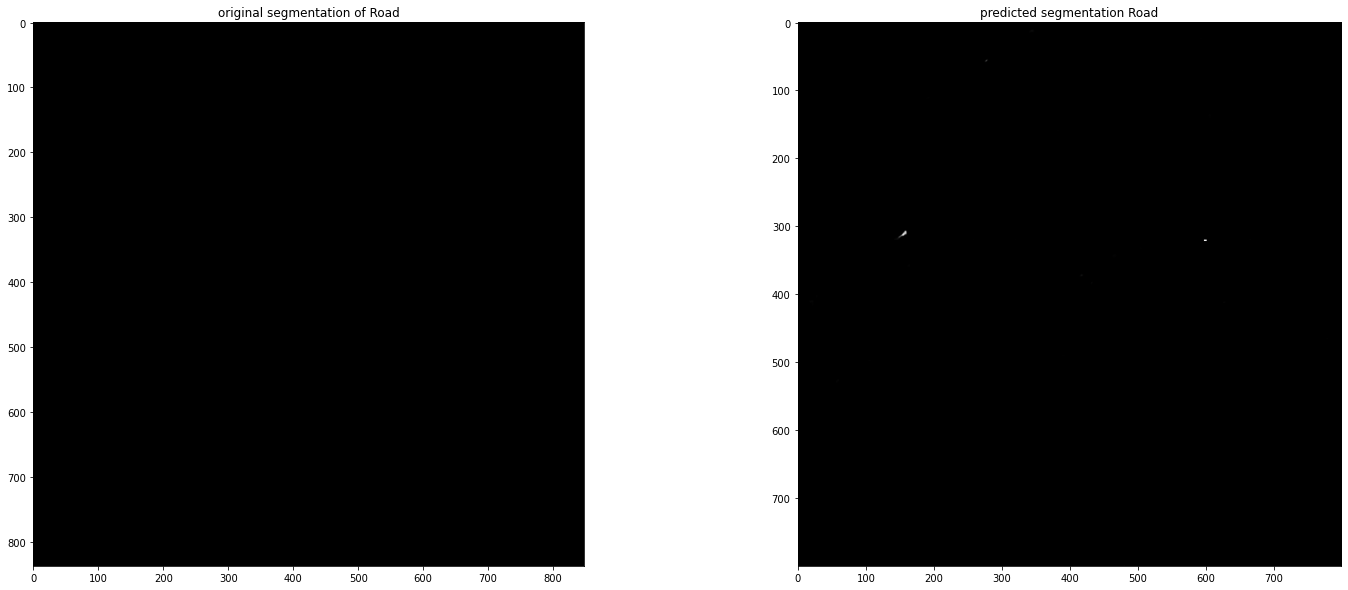

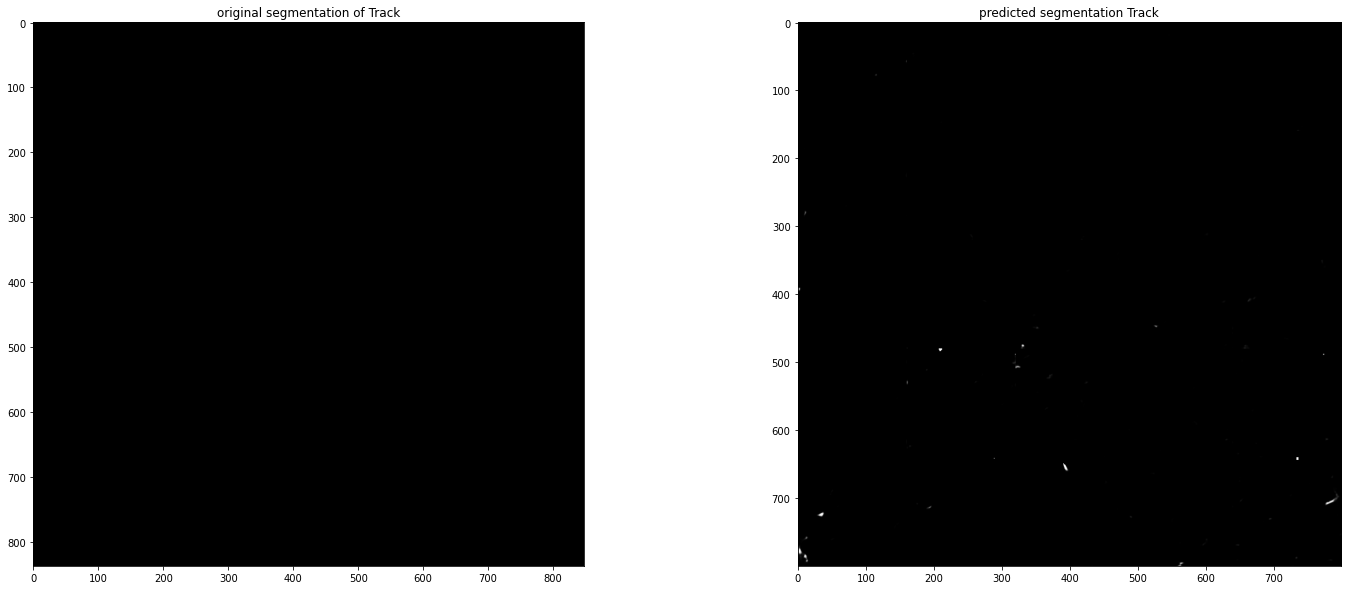

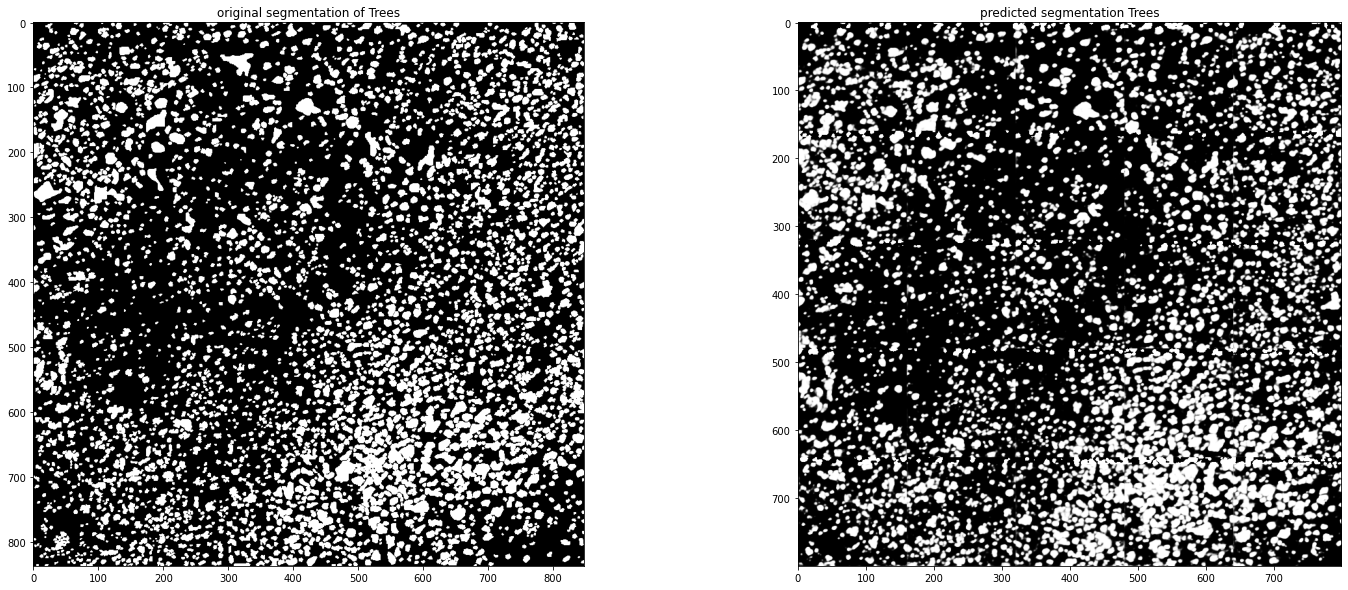

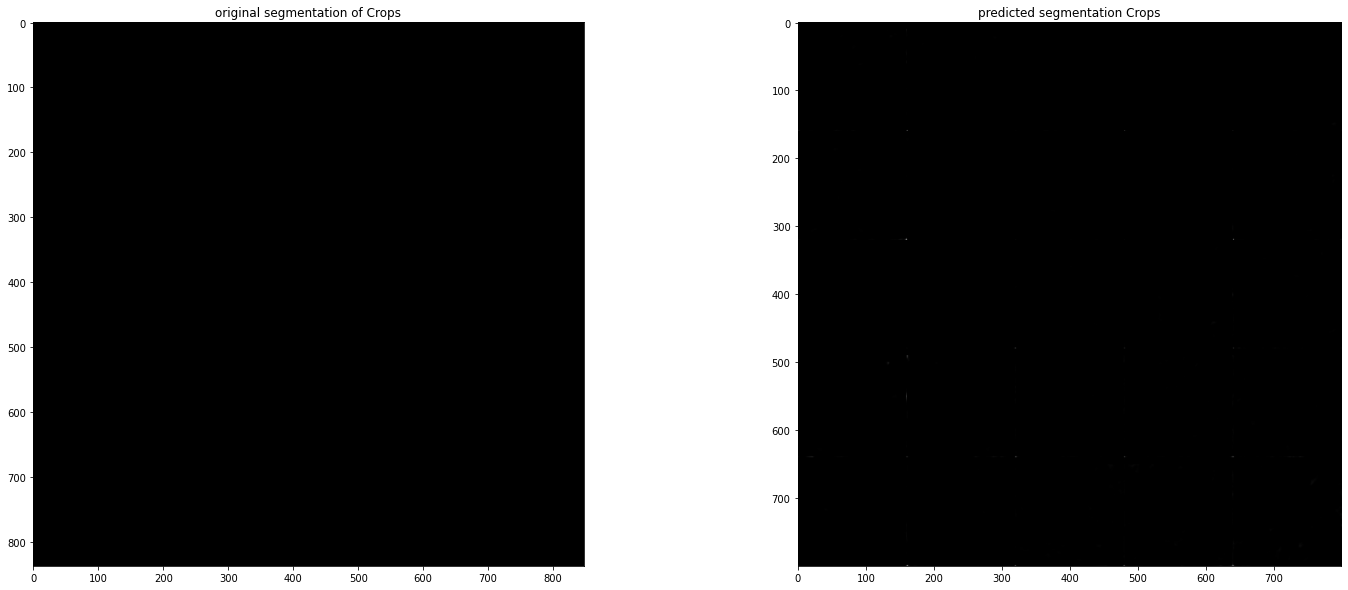

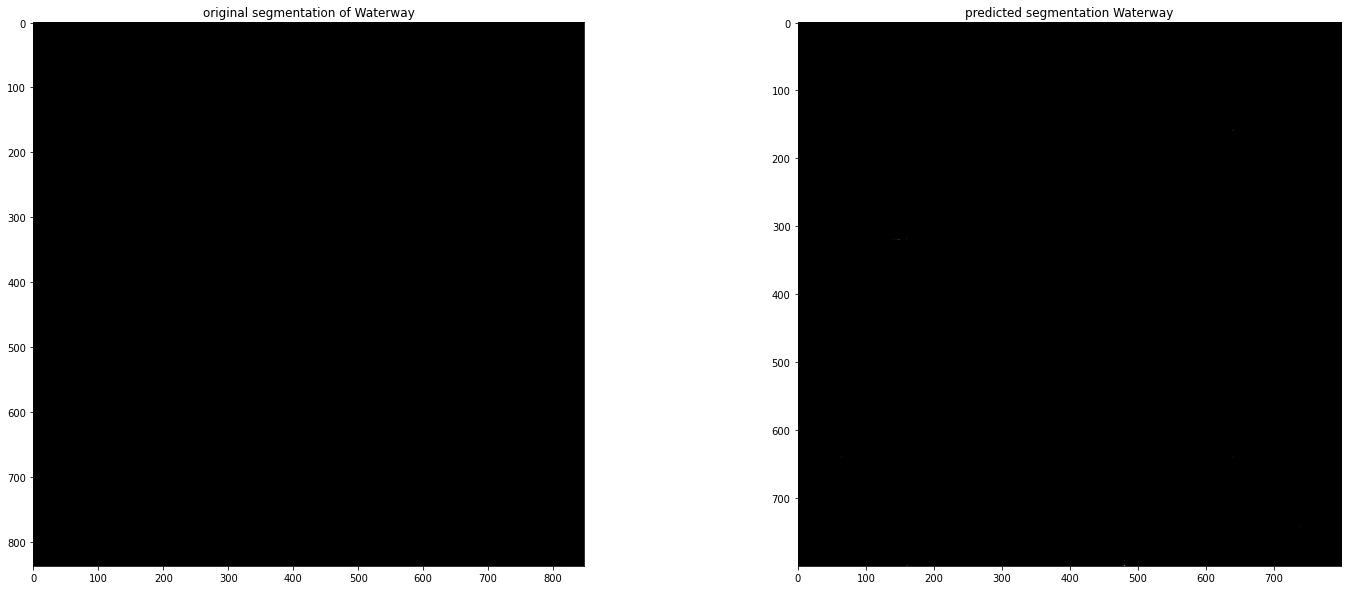

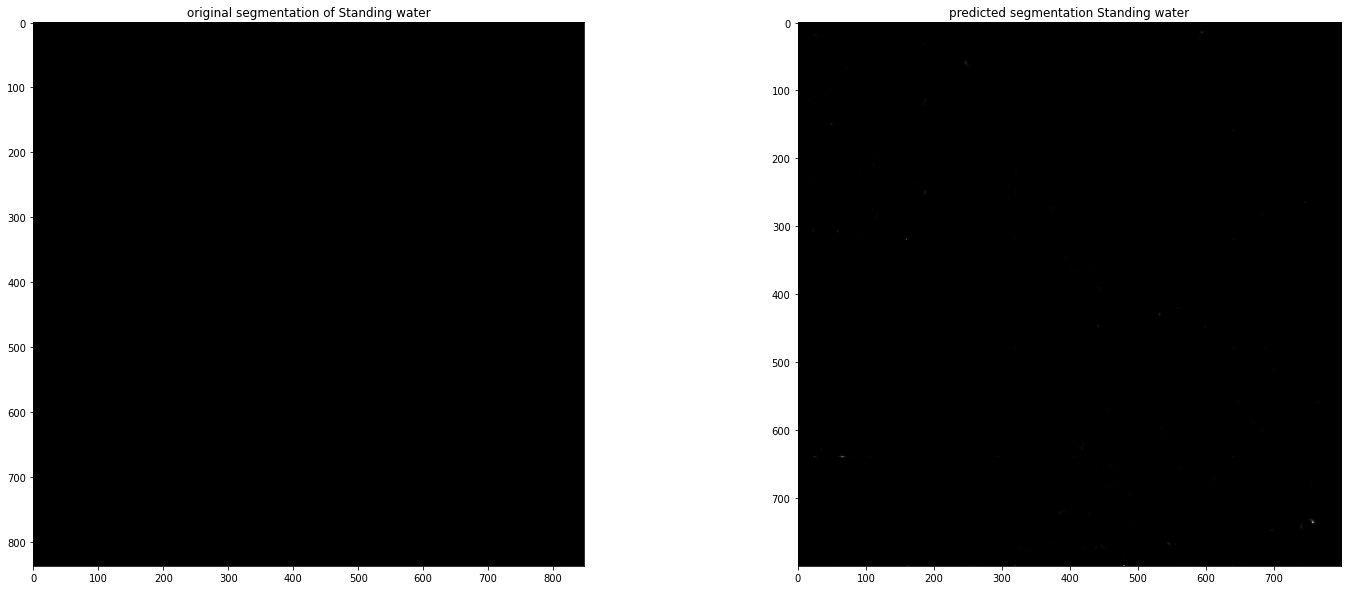

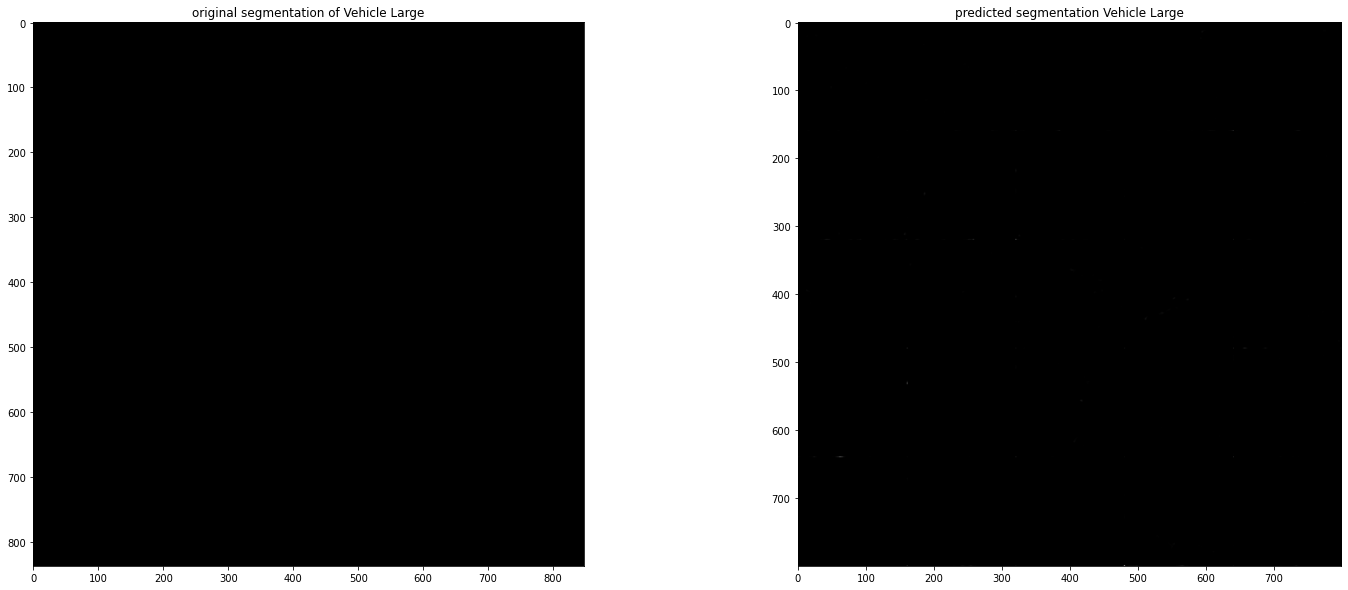

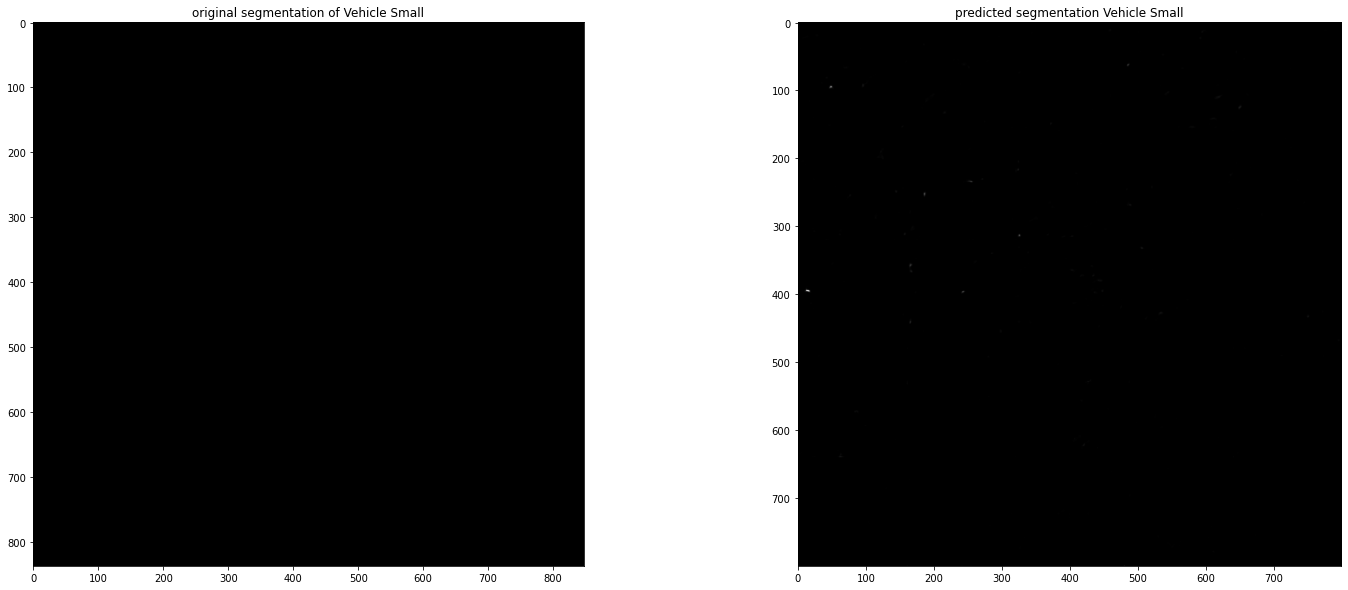

In [50]:
plot_mask('6010_4_4') #lowest jaccard score

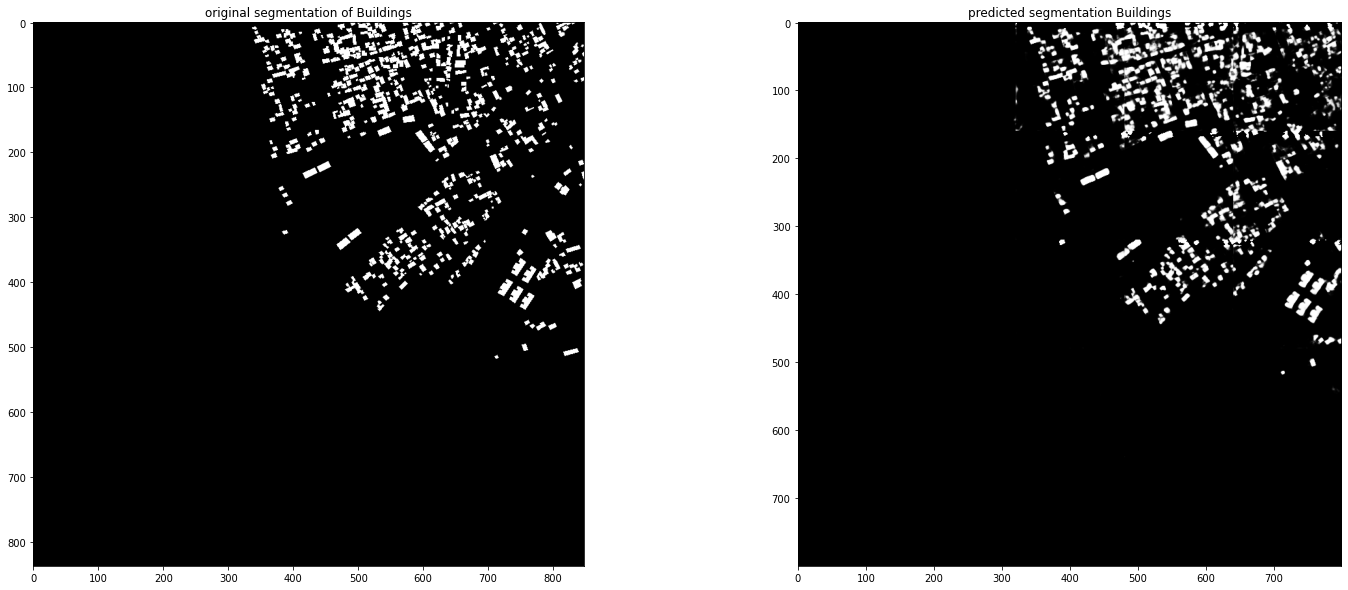

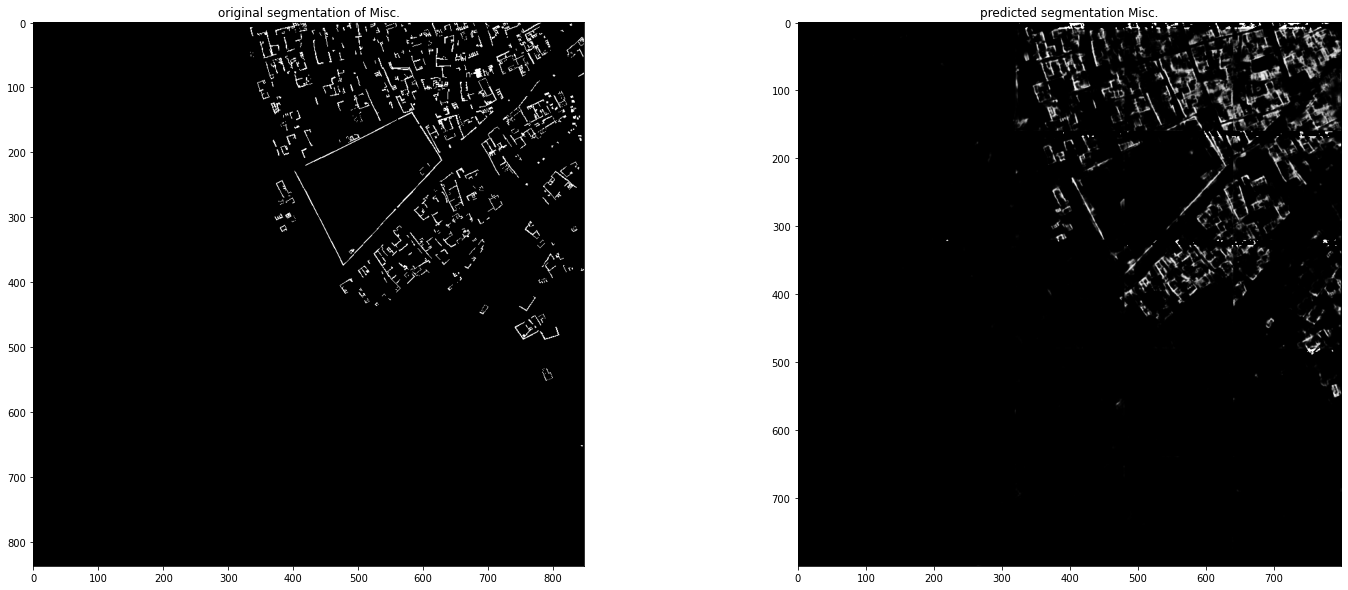

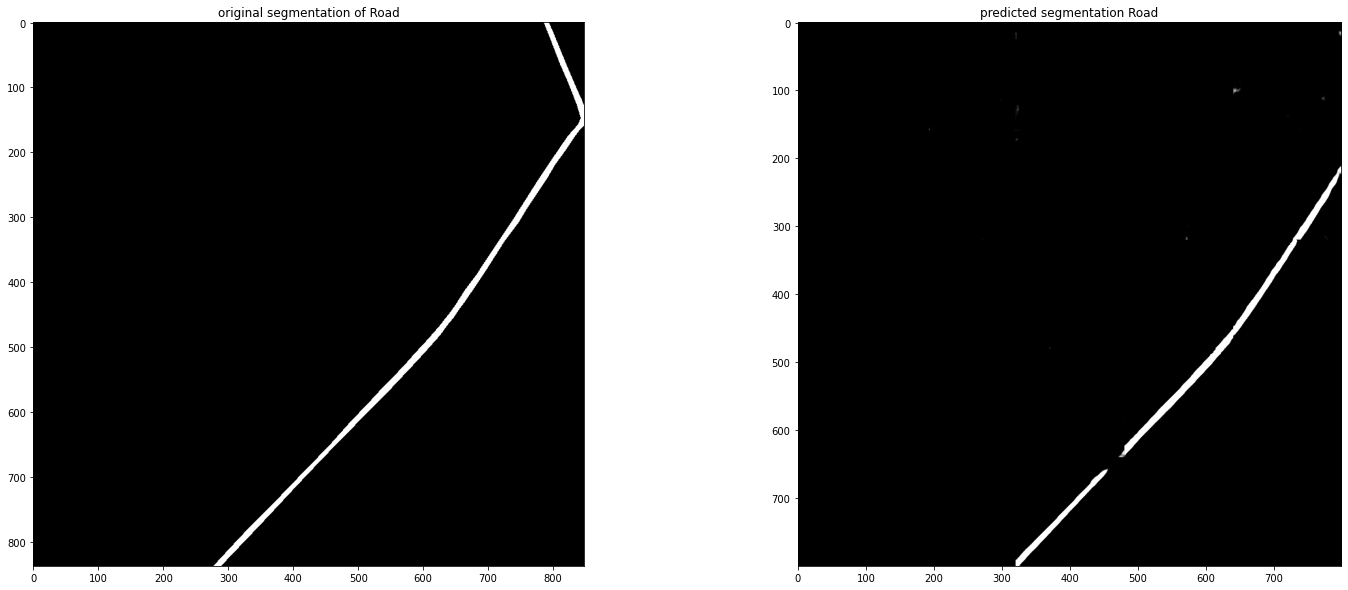

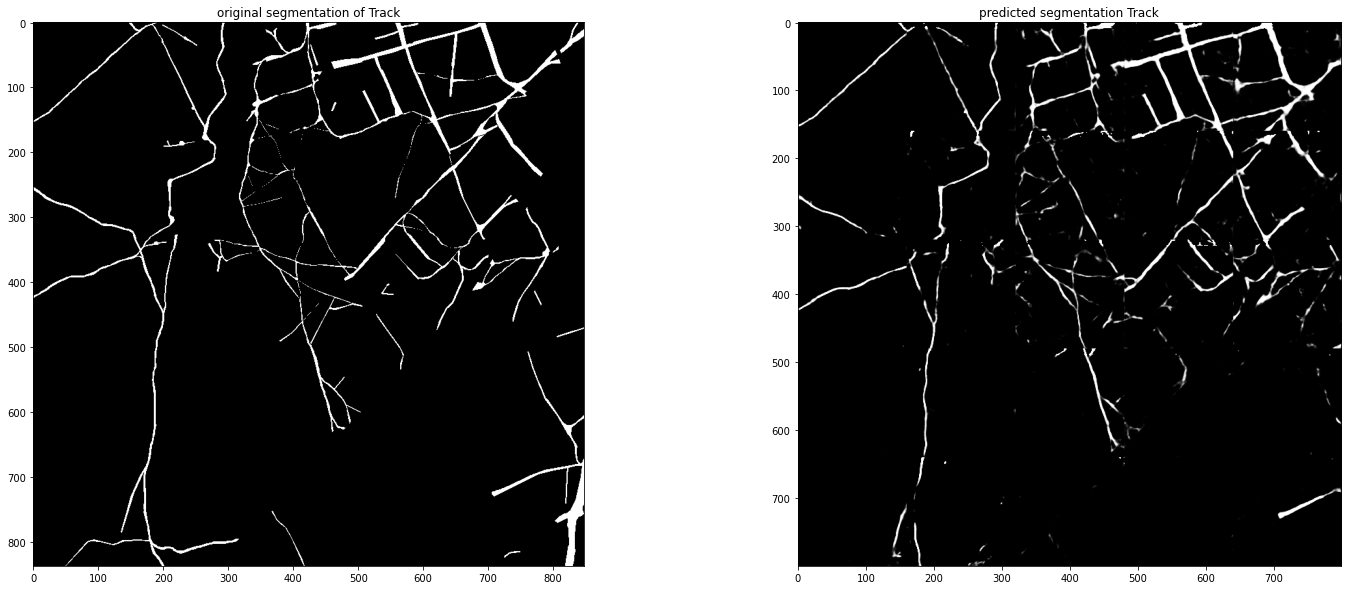

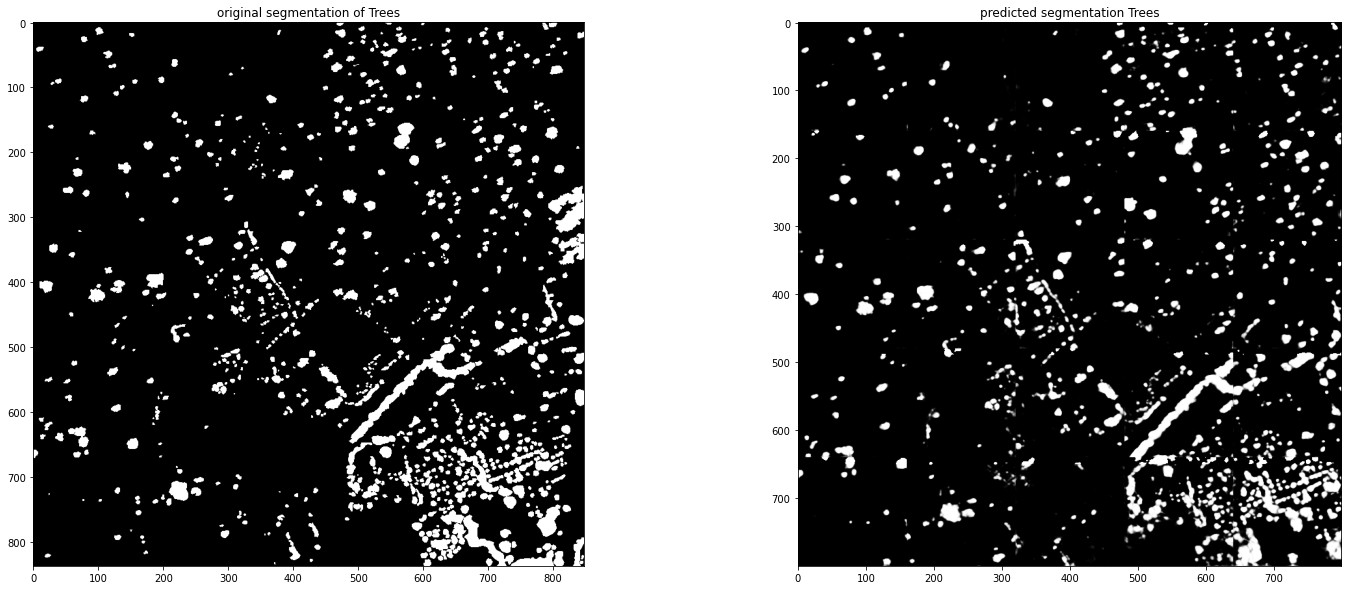

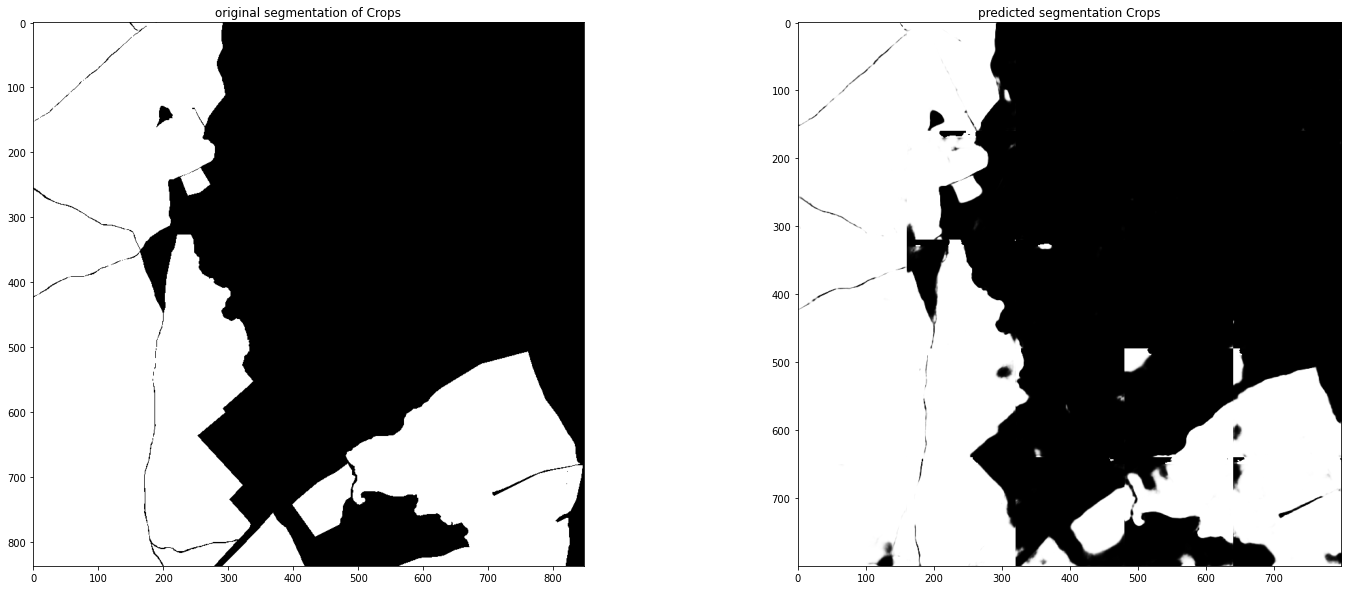

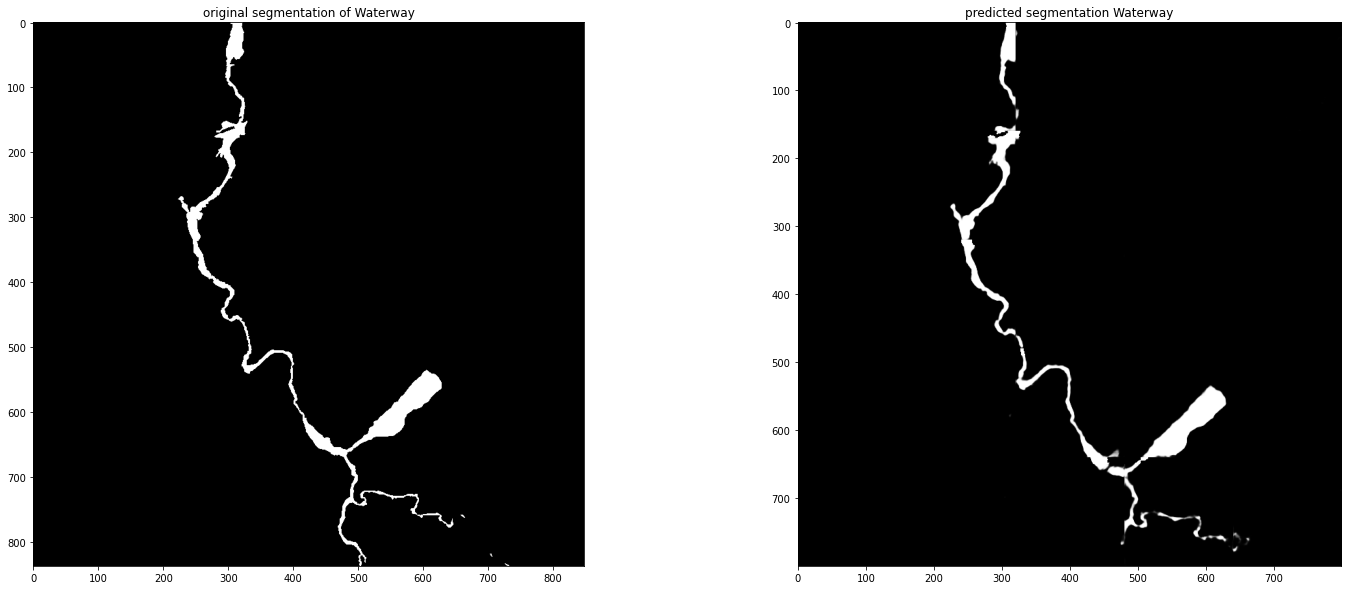

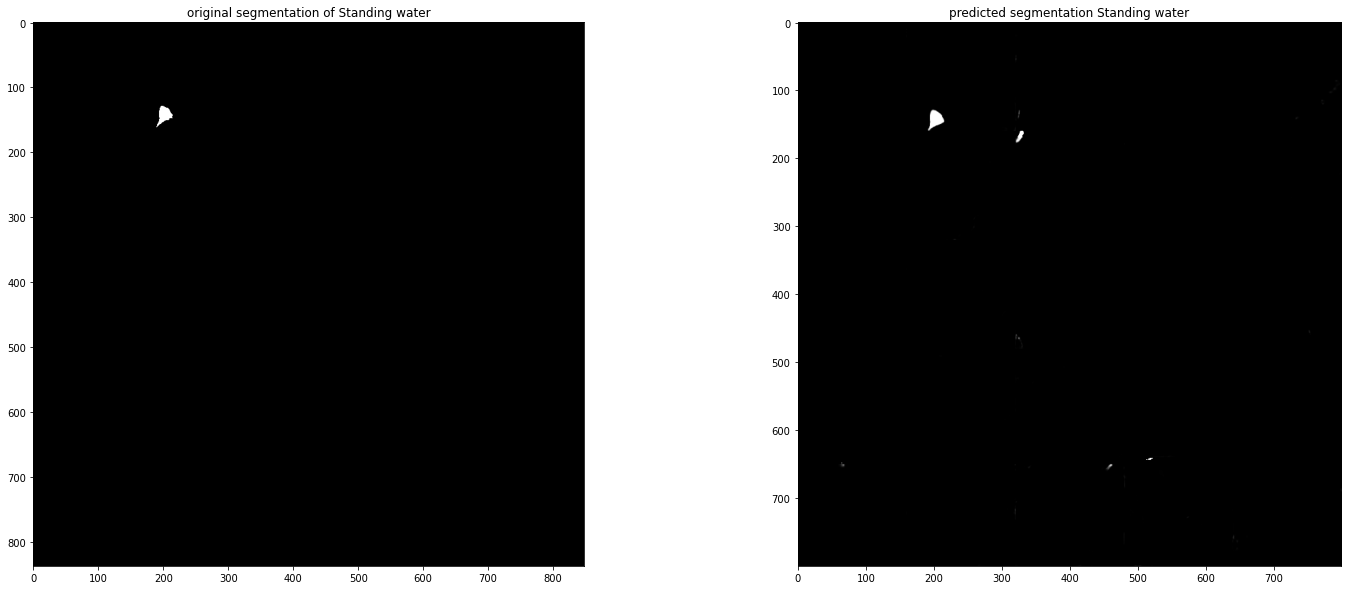

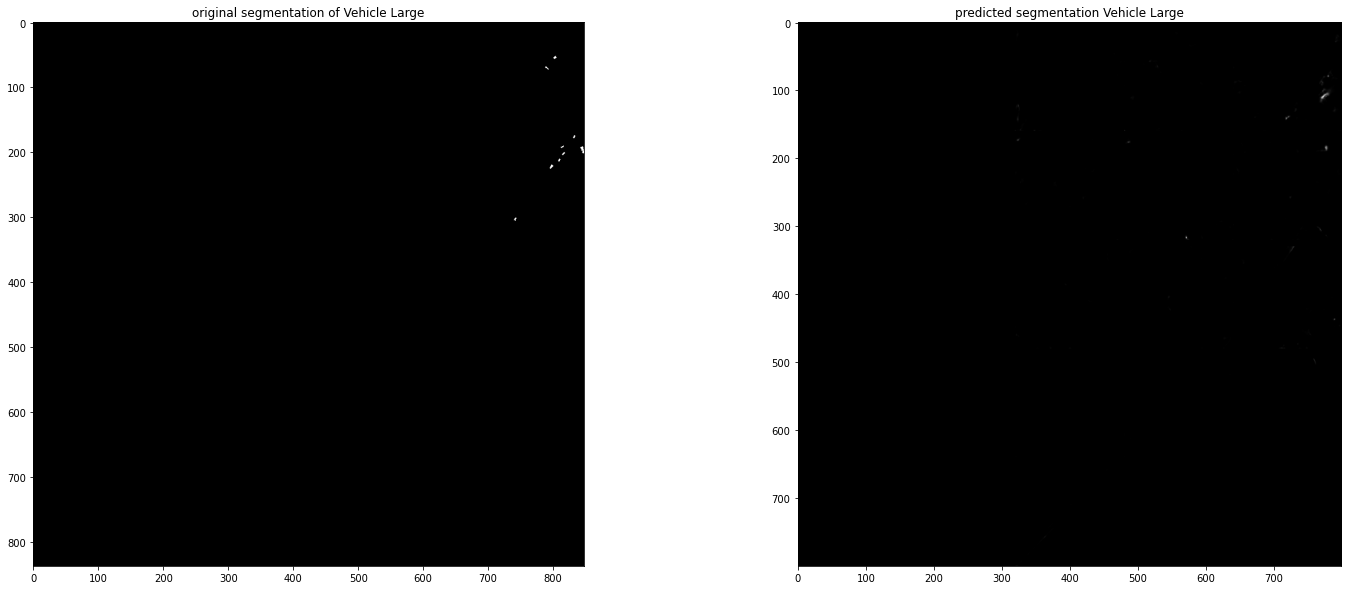

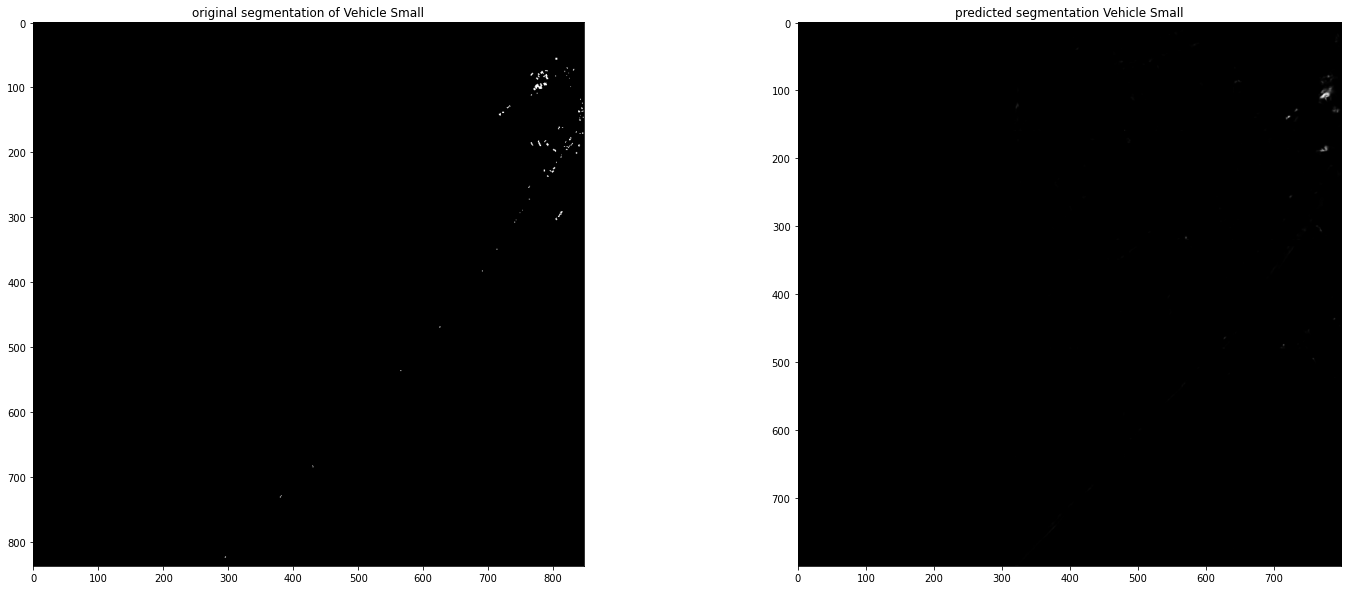

In [51]:
plot_mask('6100_2_2') #highest jaccard score

We are getting low Jaccard score when many of the objects have very few polygons due to which Jaccard score reduces and falls near zero for that particular class label. This results in reduction of overall Jaccard score of that image because of averaging of Jaccard score of all the classess